# How good is a Pythagorean Expectation Model?

Pythagorean Expectation is used to approximate the number of games a particular team should win.  Theoretical work has been done (https://arxiv.org/abs/math/0509698) in an attempt to derive the the formula based sampling from distributions of points for and against.  Over the course of a season, specific teams are expected to be more or less "lucky" than this expectation, but this "luck" does not correlate well across seasons.  The question is whether this "luck" also depends on the win percentage of the team in question.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import os


path_runs = ''
runs_records = os.listdir(path_runs)

team_ra = pd.DataFrame()

for file in runs_records:
    year = file[-4:]
    cur_year_records = pd.read_csv(path_runs+file, index_col=[0])
    cur_year_records['Year'] = int(year)
    team_ra = pd.concat([team_ra, cur_year_records])
    
team_ra.set_index(['Year', team_ra.index],inplace = True)


path_wl = ''
wl_records = os.listdir(path_wl)

team_wl = pd.DataFrame()

for file in wl_records:
    year = file[-4:]
    cur_year_records = pd.read_csv(path_wl+file, index_col=[0])
    cur_year_records['Year'] = int(year)
    team_wl = pd.concat([team_wl, cur_year_records])
    
team_wl.set_index(['Year', team_wl.index],inplace = True)
team_wl['Home W%'] = team_wl['Home_Win']/(team_wl['Home_Win']+team_wl['Home_Loss'])
team_wl['Away W%'] = team_wl['Away_Win']/(team_wl['Away_Win']+team_wl['Away_Loss'])

team_home_data = pd.concat([team_ra[['Home Runs For','Home Runs Against']],team_wl['Home W%']],axis=1)
team_away_data = pd.concat([team_ra[['Away Runs For','Away Runs Against']],team_wl['Away W%']],axis=1)

### Pythagorean Expectation Model

The general model for Pythagorean Expectation is given by
\begin{equation}
\left(\frac{\text{Points For}}{\text{Points Against}}\right)^\gamma = \frac{W\%}{1-W\%}.
\end{equation}
Taking natural logarithm of both sides
\begin{equation}
\log(\text{Points For}) - \log(\text{Points Against})=\frac{1}{\gamma}\log\left(\frac{W\%}{1-W\%}\right).
\end{equation}

Performing a linear regression across these three variables then extracts the best fit value of the exponent $\gamma$.  For both home and away data, the exponent can be found as:
\begin{equation}
\gamma_{\text{Home}} \approx 1.83, \\
\gamma_{\text{Away}} \approx 2.00,
\end{equation}
which is consistent with the commonly used value for baseball.

The Pythagorean Expectation Model does a decent job at predicting a team's win percentage. Looking at the residual plot shows the well-known problem with the Pythagorean Expectation, that it tends to regress towards the mean.  Thus, using this model to fit a team's wins will inherit this problem (as seen in other files within this project).  Nevertheless, it is a commonly used metric to evaluate a team's current ability and predict how runs can translate to wins.

R^2:  0.8041190593131888
Coefs (gamma):  [ 1.80975891 -1.85332241]


count    300.000000
mean      -0.000185
std        0.034577
min       -0.099996
25%       -0.024846
50%       -0.000486
75%        0.022804
max        0.094453
Name: W%, dtype: float64

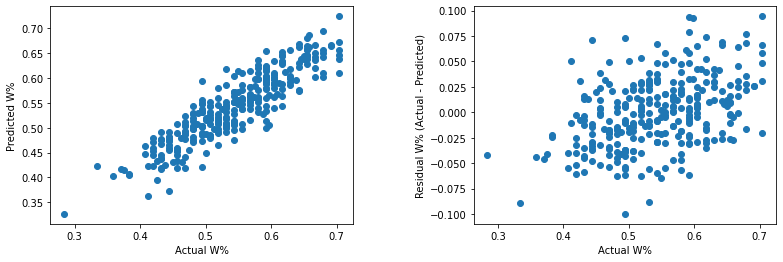

In [2]:
def log_team_data(team_data, homeaway):
    team_log = pd.DataFrame()
    team_log['Log PF'] = np.log(team_data[homeaway + ' Runs For'])
    team_log['Log PA'] = np.log(team_data[homeaway + ' Runs Against'])
    team_log['Logistic W%'] = np.log(team_data[homeaway + ' W%']/(1-team_data[homeaway + ' W%']))
    return team_log

def win_percent(log_data):
    return 1/(1+np.exp(-log_data))


    
home_log = log_team_data(team_home_data, 'Home')
away_log = log_team_data(team_away_data, 'Away')


data = home_log
X = data[['Log PF', 'Log PA']]
y = data['Logistic W%']

lin_regr = LinearRegression().fit(X, y)

print('R^2: ',lin_regr.score(X,y))
print('Coefs (gamma): ',lin_regr.coef_)


actual = win_percent(y)
actual.name = 'W%'
predict = win_percent(lin_regr.predict(X))

display((actual-predict).describe())

fig, ax = plt.subplots(1,2,figsize=(13,4))
plt.subplots_adjust(wspace=0.4)
ax[0].scatter(actual, predict)
ax[1].scatter(actual, actual-predict)
ax[0].set_xlabel('Actual W%')
ax[1].set_xlabel('Actual W%')
ax[0].set_ylabel('Predicted W%')
ax[1].set_ylabel('Residual W% (Actual - Predicted)')
plt.show()

### Using Taylor Expansion approximations to Pythagorean Expectation model

Often times, one will model a team's runs for or against on some (linear) combination of other statistics.  It will be difficult to apply these types of models directly to a Pythagorean Expectation model since the logarithm of runs cannot be easily decomposed.  Instead, we would like to use an approximation to the Pythagorean Expectation model that are linear in runs.  By holding either runs for or runs against fixed, this is made significantly easier.  Keep in mind, the exponent $\gamma$ is not generally known.

For baseball, where most teams' record is around $0.500$, a convenient method is to Taylor Expand the Pythagorean Expectation model:
\begin{equation}
\frac{\text{Points For}}{\text{Points Against}} = \left(\frac{W\%}{1-W\%}\right)^{1/\gamma} \approx 1 + \frac{4}{\gamma}(W\% - 0.5) + \frac{8}{\gamma^2}(W\% - 0.5)^2 + ...
\end{equation}
Keeping only the linear term, and assuming we hold Runs Against is fixed, we have the model:
\begin{equation}
\frac{\gamma}{4}(\text{Runs For}) + \frac{2 - \gamma}{4}(\text{Runs Against}) \approx (\text{Runs Against})\times W\%
\end{equation}

R^2:  0.7702715308301287
Coefs (gamma):  [1.7214390712738041, 1.6685755708155274]


count    300.000000
mean      -0.000111
std        0.035736
min       -0.098563
25%       -0.025569
50%        0.001333
75%        0.023702
max        0.097058
dtype: float64

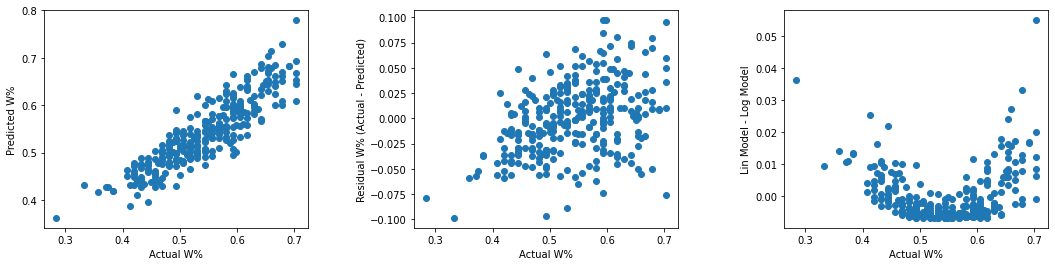

In [3]:
team_home_data_lin = team_home_data.copy()
team_home_data_lin.columns = ['RF','RA','W%']
team_home_data_lin['RAxW%'] = team_home_data['Home Runs Against'] * team_home_data['Home W%']

team_away_data_lin = team_away_data.copy()
team_away_data_lin.columns = ['RF','RA','W%']
team_away_data_lin['RAxW%'] = team_away_data['Away Runs Against'] * team_away_data['Away W%']


data_lin = team_home_data_lin
X_lin = data_lin[['RF', 'RA']]
y_lin = data_lin['RAxW%']

lin_regr_lin = LinearRegression().fit(X_lin, y_lin)

print('R^2: ',lin_regr_lin.score(X_lin,y_lin))
print('Coefs (gamma): ',[lin_regr_lin.coef_[0]*4,2-lin_regr_lin.coef_[1]*4])


actual_lin = y_lin/X_lin['RA']
actual_lin.name = 'W%'
predict_lin = lin_regr_lin.predict(X_lin)/X_lin['RA']

display((actual_lin-predict_lin).describe())

fig, ax = plt.subplots(1,3,figsize=(18,4))
plt.subplots_adjust(wspace=0.4)
ax[0].scatter(actual_lin, predict_lin)
ax[1].scatter(actual_lin, actual_lin-predict_lin)
ax[2].scatter(actual, predict_lin - predict)
ax[0].set_xlabel('Actual W%')
ax[1].set_xlabel('Actual W%')
ax[2].set_xlabel('Actual W%')
ax[0].set_ylabel('Predicted W%')
ax[1].set_ylabel('Residual W% (Actual - Predicted)')
ax[2].set_ylabel('Lin Model - Log Model')
plt.show()

Using the linear approximation have a relatively small effect on the outcome, only producing noticeable effects for extreme values of the win percentage.  The Pythagorean Expectation still has the regression effect, however it is somewhat lessened for home data.  This is due to home field advantage resulting in an average win percentage above $0.500$.  Since the linear model will overpredict extreme values (compared to the previous model), the residuals are slightly pulled back to zero at these high win percentages.  Conversely, this also results in a worse model for the away data.